In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash 
!sudo apt-get install git-lfs 
!git lfs install
!git lfs clone https://github.com/BrainTankDeepLearning/Week4.git

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

import pandas as pd

from torch.utils.data import Dataset, DataLoader

class AgeGenEthDataset(Dataset):
    def __init__(self, csv_name = 'week4/age_gender.csv'):
        self.df = pd.read_csv(csv_name)
        self.df = self.df.to_numpy()

        self.meta_data = list()

        if not os.path.isdir("images"):
            os.mkdir("images")

        for i in range(len(self.df)):
            row = self.df[i]
            row[0] = row[0] / 35 - 1
            self.meta_data.append(row[0:3])

            image_path = os.path.join("images", f"image{str(i).zfill(4)}.png")

            if not os.path.isfile(image_path):
                pixel_string = row[4]
                pixels = [int(x) for x in pixel_string.split()]

                pixels = np.array(pixels, dtype = np.float64)
                pixels = np.reshape(pixels, (48, 48))

                mean = np.mean(pixels)
                std = np.std(pixels)

                im = Image.fromarray(pixels)
                im = im.convert("L")
                im.save(image_path)

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean = [0.490],
                std = [0.197]
            ),
        ])

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        md_row = self.meta_data[idx]

        age = torch.tensor(md_row[0])
        ethnicity = torch.tensor(md_row[1])
        gender = torch.tensor(md_row[2])

        image_file_name = os.path.join("images", f"image{str(idx).zfill(4)}.png")
        image = Image.open(image_file_name)
        image = self.transforms(image)

        return {"age": age, "ethnicity": ethnicity, "gender": gender, "image": image}

def create_dataloaders(path = "Week4/age_gender.csv"):
  ds = AgeGenEthDataset("Week4/age_gender.csv")

  train_ds, test_ds = torch.utils.data.random_split(ds, (19000, 4705))

  train_loader = DataLoader(train_ds, batch_size = 32, drop_last = True, shuffle = True)
  test_loader = DataLoader(test_ds, batch_size = 32, drop_last = True, shuffle = True)

  return train_loader, test_loader

def display_data(images, prediction = None, target = None):
  #in format [age, gender, eth]

  # settings
  h, w = 20, 20        # for raster image
  nrows, ncols = 3, 3  # array of sub-plots
  figsize = [7, 7]     # figure size, inches

  # create figure (fig), and array of axes (ax)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

  # plot simple raster image on each sub-plot
  for i, axi in enumerate(ax.flat):
    if i >= 9:
      break
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = images[i] * -1
    axi.imshow(img.squeeze(), cmap='Greys', alpha=1)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    if prediction is None and target is not None:
      axi.set_title(f"T - Age:{int(target[i][0].item())} Gen:{int(target[i][1].item())} Eth:{int(target[i][2].item())}")
    if prediction is not None and target is None:
      axi.set_title(f"P - Age:{int(prediction[i][0].item())} Gen:{int(prediction[i][1].item())} Eth:{int(prediction[i][2].item())}")
    if prediction is not None and target is not None:
      string = f"P - Age:{int(prediction[i][0].item())} Gen:{int(prediction[i][1].item())} Eth:{int(prediction[i][2].item())}" + "\n" + \
        f"T - Age:{int(target[i][0].item())} Gen:{int(target[i][1].item())} Eth:{int(target[i][2].item())}"
      axi.set_title(string)

  plt.tight_layout(True)
  plt.show()

def create_bunch(age, gen, eth, unnormalize_age = True):
  if unnormalize_age:
    age = (age.unsqueeze(1) + 1) * 35
  else:
    age = age.unsqueeze(1)
  
  gen = gen.unsqueeze(1)
  eth = eth.unsqueeze(1)

  out = torch.cat([age, gen, eth], dim = 1)

  return out

def softmax_loss(prediction, one_hot):
  prediction = torch.log(prediction)

  target = torch.empty(size = (len(one_hot), ), dtype = torch.long)
  for i, row in enumerate(one_hot):
    index = (row == 1).nonzero(as_tuple=True)[0]
    target[i] = index.item()

  loss = torch.nn.functional.nll_loss(prediction, target)

  return loss

def mse_loss(prediction, target):
  loss = torch.nn.functional.mse_loss(prediction, target)

  return loss

def create_ground_truths(ages, gens, eths):
  gen_out = torch.zeros((32, 2))
  eth_out = torch.zeros((32, 6))

  for i in range(len(gens)):
    gen_idx = gens[i].item()
    eth_idx = eths[i].item()

    gen_out[i][gen_idx] = 1.0
    eth_out[i][eth_idx] = 1.0

  return ages, gen_out, eth_out


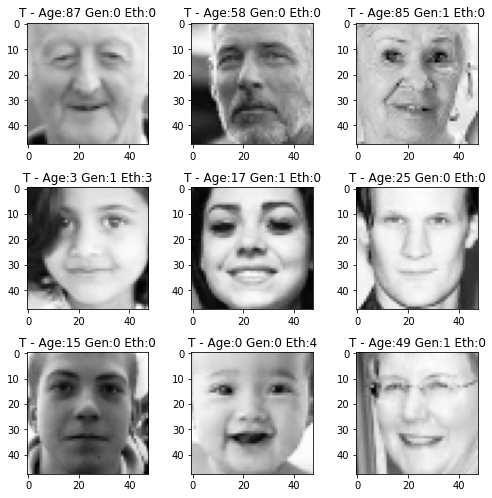

In [33]:
# Gender labls
GENDERS = { 
    0: "Male", 
    1: "Female"
}

# Ethnicity labels
ETHNICITIES = { 
    0: "White", 
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Hispanic"
}

class AgeGenEthModel(torch.nn.Module):
  def __init__(self):
    super(AgeGenEthModel, self).__init__() 
    pass


  def forward(self, image):
    pass


def train(model, train_dataset, optim):
  pass

def test(model, test_dataset):
  total_age_loss = 0
  total_gen_loss = 0
  total_eth_loss = 0

  total_age_correct = 0
  total_gen_correct = 0
  total_eth_correct = 0

  total_training_loss = 0
  for batch in test_dataset:
    images = batch['image']
    ages = batch['age']
    gens = batch['gender']
    eths = batch['ethnicity']
    
    age_gt, gen_gt, eth_gt = create_ground_truths(ages, gens, eths)

    age_pred, gen_pred, eth_pred = model(images)

    age_loss = mse_loss(age_pred, age_gt)
    gen_loss = softmax_loss(gen_pred, gen_gt)
    eth_loss = softmax_loss(eth_pred, eth_gt)

    total_loss = age_loss + gen_loss + eth_loss

    total_training_loss += total_loss.item()
    total_age_loss += age_loss.item()
    total_gen_loss += gen_loss.item()
    total_eth_loss += eth_loss.item()

    max_gen = torch.argmax(gen_pred, axis = 1)
    max_eth = torch.argmax(eth_pred, axis = 1)

    ages_gt_unnormalized = ((ages + 1) * 35)
    ages_pred_unnormalized = ((age_pred + 1) * 35)

    ages_correct_over = (ages_pred_unnormalized >= ages_gt_unnormalized - 10)
    ages_correct_under = (ages_pred_unnormalized <= ages_gt_unnormalized + 10)
    ages_correct = (ages_correct_over == ages_correct_under)
    gens_correct = (max_gen == gens)
    eths_correct = (max_eth == eths)

    total_age_correct += torch.sum(ages_correct == True).item()
    total_gen_correct += torch.sum(gens_correct == True).item()
    total_eth_correct += torch.sum(eths_correct == True).item()

    '''
    pred_bunch =  create_bunch(age_pred, max_gen, max_eth)
    gt_bunch = create_bunch(ages, gens, eths)
    display_data(images, prediction = pred_bunch, target = gt_bunch)
    '''

  total_training_loss /= len(test_dataset)
  total_age_loss /= len(test_dataset)
  total_gen_loss /= len(test_dataset)
  total_eth_loss /= len(test_dataset)

  print(f"loss: {total_training_loss}, age loss: {total_age_loss}, gen loss: {total_gen_loss}, eth loss: {total_eth_loss}")
  print(f"Age Correct Rate (within 10 years): {total_age_correct/(len(test_dataset) * 32)} Gender Correct Rate: {total_gen_correct/(len(test_dataset) * 32)} Ethnicity Correct Rate: {total_eth_correct/(len(test_dataset) * 32)}")


if __name__ == "__main__":
  pass
